In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


### Reading the data from dataset.

In [2]:
data = pd.read_csv("car_price_prediction.csv")

In [3]:
data.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [4]:
print(data.shape)

data.info()

(19237, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-

### Data cleaning, pre-processing and exploring process.

#### checking for duplicate values and removing them:

In [5]:
data.duplicated().sum()

np.int64(313)

In [6]:
data.drop_duplicates(inplace= True)

#### Checking for missing values and removing them:

In [7]:
data.isna().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

#### No missing values are present.

In [8]:
data.describe()

,ID,Price,Prod. year,Cylinders,Airbags
count,1.892400e+04,1.892400e+04,18924.000000,18924.000000,18924.000000
mean,4.557538e+07,1.858744e+04,2010.914236,4.580216,6.568379
std,9.375468e+05,1.921356e+05,5.665749,1.200223,4.322323
min,2.074688e+07,1.000000e+00,1939.000000,1.000000,0.000000
25%,4.569501e+07,5.331000e+03,2009.000000,4.000000,4.000000
50%,4.577191e+07,1.317200e+04,2012.000000,4.000000,6.000000
75%,4.580174e+07,2.206300e+04,2015.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,16.000000,16.000000


#### Removing ID and doors column which may affect the modal since it is not that significant:

In [9]:
data = data.drop(["ID", "Doors"], axis=1)

In [10]:
data.head()

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Wheel,Color,Airbags
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,Left wheel,Silver,12
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,Left wheel,Black,8
2,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,Right-hand drive,Black,2
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,Left wheel,White,0
4,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,Left wheel,Silver,4


#### Since Levy column has '-' which might be a useless data value, we will convert it to 0 and type of the column to float:

In [11]:
data['Levy']=data['Levy'].replace('-','0')

data['Levy'] = data['Levy'].astype('float64')

#### Converting Prod. year to be age of the car instead since it will be easier to deal to with instead of the year of production since it also has a impact on a vehicle price:

In [12]:
current_date = dt.datetime.now()

data["Age"] = current_date.year - data["Prod. year"]

data = data.drop("Prod. year", axis=1)

#### Converting cylinder to int and not float 

In [13]:
data['Cylinders'] = data['Cylinders'].astype(int)
data['Cylinders']

0        6
1        6
2        4
3        4
4        4
        ..
19232    4
19233    4
19234    4
19235    4
19236    4
Name: Cylinders, Length: 18924, dtype: int64

#### Converting mileage to an integer value and removing "km":

In [14]:
data["Mileage"] = data["Mileage"].str.replace("km", "")

data.Mileage = data.Mileage.astype("Int64")

print(data["Mileage"])

0        186005
1        192000
2        200000
3        168966
4         91901
          ...  
19232    300000
19233    161600
19234    116365
19235     51258
19236    186923
Name: Mileage, Length: 18924, dtype: Int64


In [15]:
print(data["Engine volume"].unique())

['3.5' '3' '1.3' '2.5' '2' '1.8' '2.4' '4' '1.6' '3.3' '2.0 Turbo'
 '2.2 Turbo' '4.7' '1.5' '4.4' '3.0 Turbo' '1.4 Turbo' '3.6' '2.3'
 '1.5 Turbo' '1.6 Turbo' '2.2' '2.3 Turbo' '1.4' '5.5' '2.8 Turbo' '3.2'
 '3.8' '4.6' '1.2' '5' '1.7' '2.9' '0.5' '1.8 Turbo' '2.4 Turbo'
 '3.5 Turbo' '1.9' '2.7' '4.8' '5.3' '0.4' '2.8' '3.2 Turbo' '1.1' '2.1'
 '0.7' '5.4' '1.3 Turbo' '3.7' '1' '2.5 Turbo' '2.6' '1.9 Turbo'
 '4.4 Turbo' '4.7 Turbo' '0.8' '0.2 Turbo' '5.7' '4.8 Turbo' '4.6 Turbo'
 '6.7' '6.2' '1.2 Turbo' '3.4' '1.7 Turbo' '6.3 Turbo' '2.7 Turbo' '4.3'
 '4.2' '2.9 Turbo' '0' '4.0 Turbo' '20' '3.6 Turbo' '0.3' '3.7 Turbo'
 '5.9' '5.5 Turbo' '0.2' '2.1 Turbo' '5.6' '6' '0.7 Turbo' '0.6 Turbo'
 '6.8' '4.5' '0.6' '7.3' '0.1' '1.0 Turbo' '6.3' '4.5 Turbo' '0.8 Turbo'
 '4.2 Turbo' '3.1' '5.0 Turbo' '6.4' '3.9' '5.7 Turbo' '0.9' '0.4 Turbo'
 '5.4 Turbo' '0.3 Turbo' '5.2' '5.8' '1.1 Turbo']


#### Removing "turbo" keyword in Engine volume and converting it into a float type:

In [16]:
data["Engine volume"] = data["Engine volume"].str.replace("Turbo", "")

data["Engine volume"] = data["Engine volume"].astype("float64")

data["Engine volume"].unique()

array([ 3.5,  3. ,  1.3,  2.5,  2. ,  1.8,  2.4,  4. ,  1.6,  3.3,  2.2,
        4.7,  1.5,  4.4,  1.4,  3.6,  2.3,  5.5,  2.8,  3.2,  3.8,  4.6,
        1.2,  5. ,  1.7,  2.9,  0.5,  1.9,  2.7,  4.8,  5.3,  0.4,  1.1,
        2.1,  0.7,  5.4,  3.7,  1. ,  2.6,  0.8,  0.2,  5.7,  6.7,  6.2,
        3.4,  6.3,  4.3,  4.2,  0. , 20. ,  0.3,  5.9,  5.6,  6. ,  0.6,
        6.8,  4.5,  7.3,  0.1,  3.1,  6.4,  3.9,  0.9,  5.2,  5.8])

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18924 entries, 0 to 19236
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             18924 non-null  int64  
 1   Levy              18924 non-null  float64
 2   Manufacturer      18924 non-null  object 
 3   Model             18924 non-null  object 
 4   Category          18924 non-null  object 
 5   Leather interior  18924 non-null  object 
 6   Fuel type         18924 non-null  object 
 7   Engine volume     18924 non-null  float64
 8   Mileage           18924 non-null  Int64  
 9   Cylinders         18924 non-null  int64  
 10  Gear box type     18924 non-null  object 
 11  Drive wheels      18924 non-null  object 
 12  Wheel             18924 non-null  object 
 13  Color             18924 non-null  object 
 14  Airbags           18924 non-null  int64  
 15  Age               18924 non-null  int64  
dtypes: Int64(1), float64(2), int64(4), object(9)


### Visualizing and analyzing process


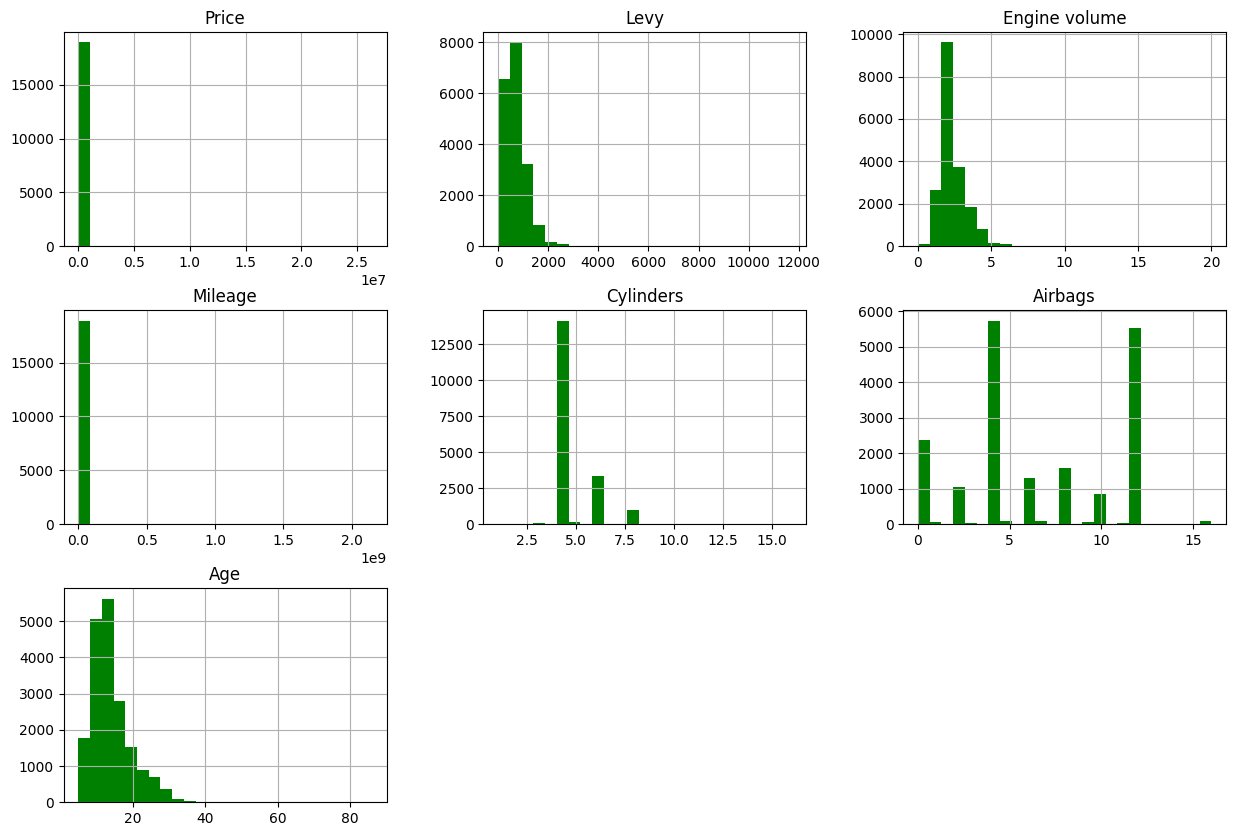

In [18]:
data.hist(bins=25,figsize=(15,10),color='green')
plt.show()

#### Observations:
1) Levy column is always between 0 and 2000.
2) Most cars are new because they have mileage of 0.
3) Most cars are 10 to 15 years old, majority being less than 20 years old.
4) Engine volumes is always in the range from 0 to 5.
5) Most cars have 4 cylinder engines.


#### Checking most frequent vehicle category:

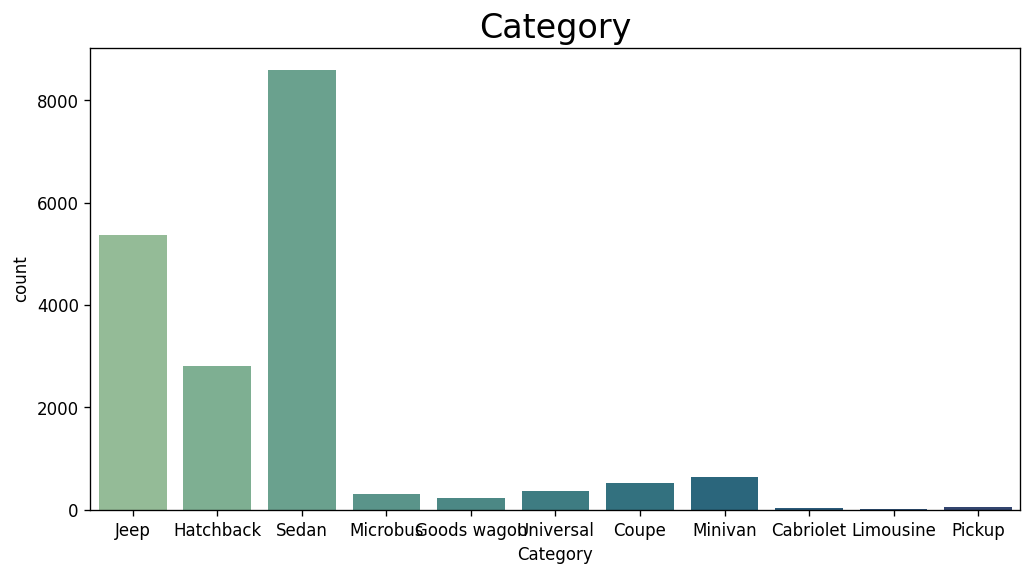

In [19]:
plt.subplots(figsize=(10,5), dpi=120)
sns.countplot(data= data, x='Category', palette='crest')
plt.title("Category",fontsize=20)
plt.show()

#### Sedan is majority, followed by hatchbacks and jeeps.

#### Checking the vechicle colors:

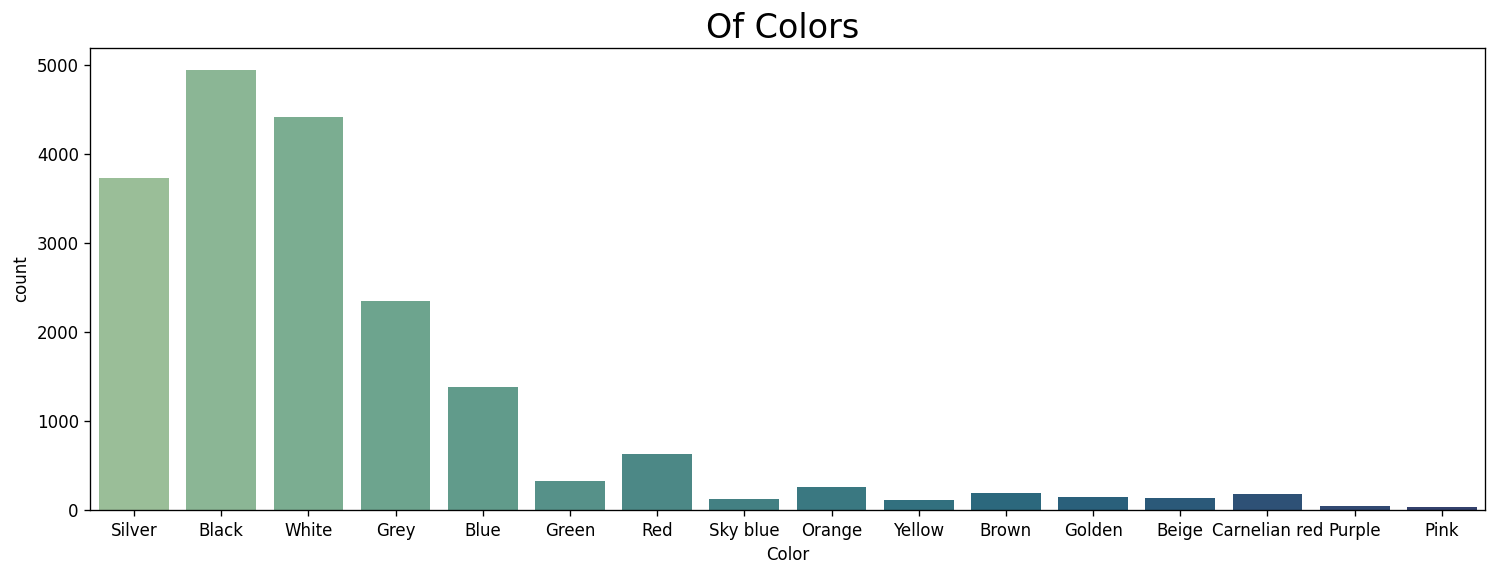

In [20]:
plt.subplots(figsize=(15,5), dpi=120)
sns.countplot(data= data, x='Color',palette='crest')
plt.title("Of Colors ",fontsize=20)
plt.show()

#### Most sold color type are black, silver, white and grey.

#### Checking most sold gear box type and fuel type:

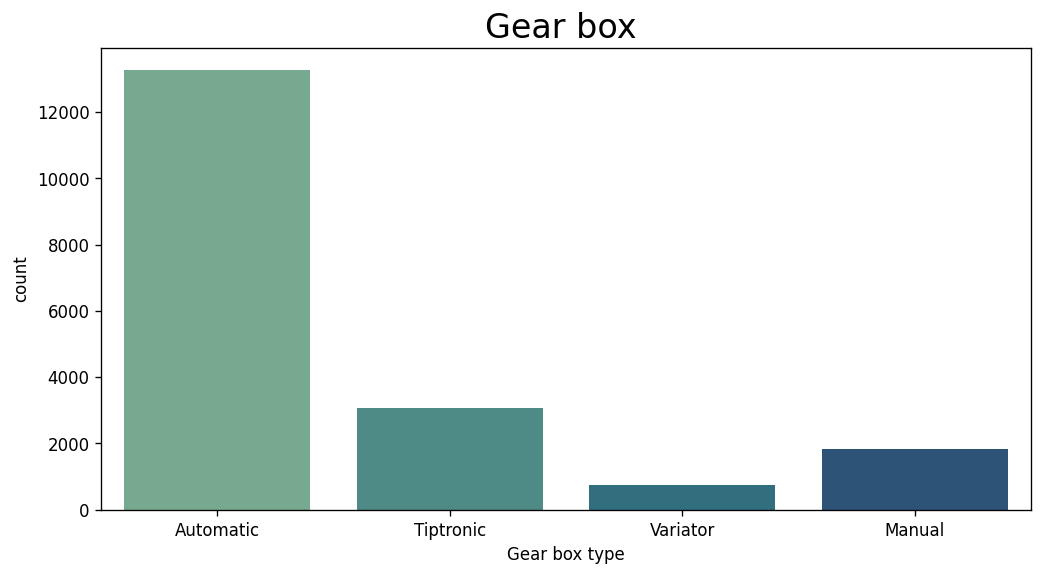

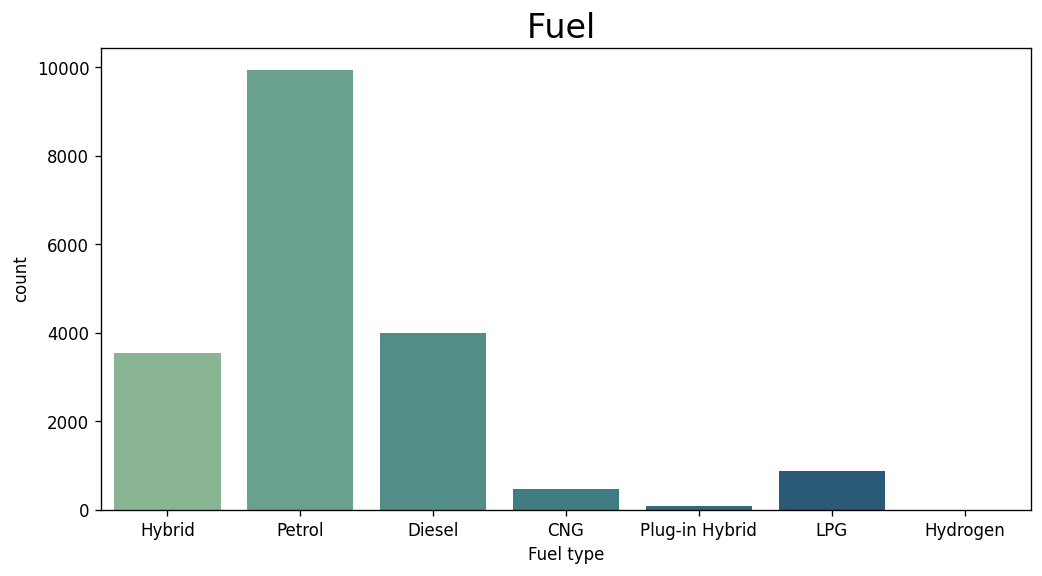

In [21]:
plt.subplots(figsize=(10,5), dpi=120)
sns.countplot(data= data, x='Gear box type',palette='crest')
plt.title("Gear box ",fontsize=20)
plt.show()

plt.subplots(figsize=(10,5), dpi=120)
sns.countplot(data= data, x='Fuel type',palette='crest')
plt.title("Fuel ",fontsize=20)
plt.show()

#### Most cars sold are automatic and uses petrol, while hybrid is closely with diesel engines.

#### Checking top 5 car manufactuers: 

Manufacturer
HYUNDAI          3729
TOYOTA           3606
MERCEDES-BENZ    2043
FORD             1088
CHEVROLET        1047
Name: count, dtype: int64


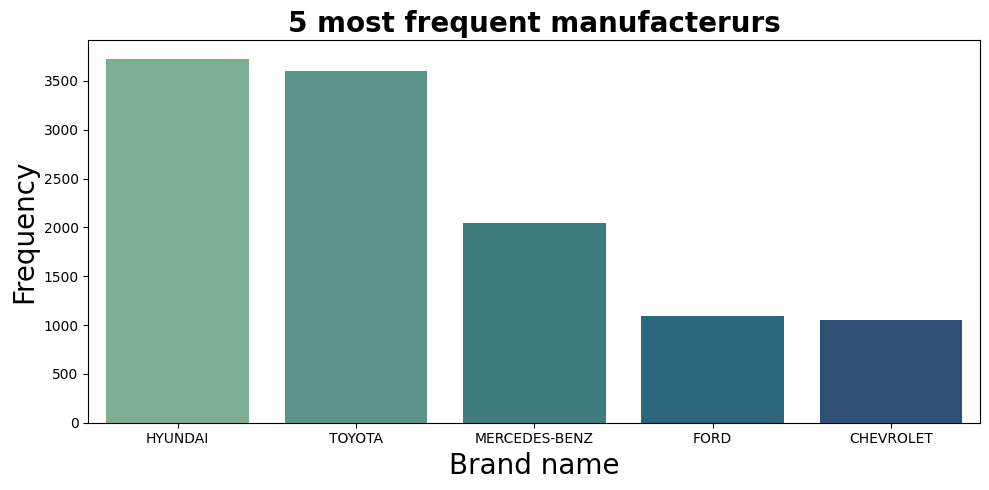

In [22]:
manufacterers = data.Manufacturer.value_counts().sort_values(ascending=False)[:5]

print(manufacterers)

plt.figure(figsize=(10, 5))
sns.barplot(x=manufacterers.index, y=manufacterers,palette='crest',linewidth = 4)
plt.title('5 most frequent manufacterurs',loc='center',fontweight='bold',fontsize=20)
plt.xlabel('Brand name',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.tight_layout()
plt.show()


#### Checking average price for top 5 car manufacturers:

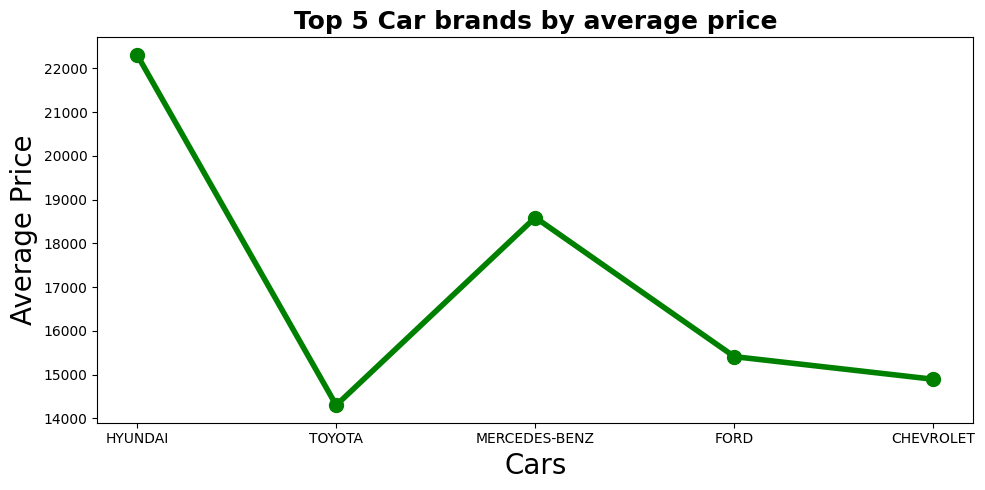

In [23]:
manufacterers_average_price = [data[data['Manufacturer']==i]['Price'].mean() for i in list(manufacterers.index)]

plt.figure(figsize=(10,5))
plt.plot(manufacterers.index, manufacterers_average_price,color='g',
         linewidth = 4, marker='o',markersize = 10)
plt.title('Top 5 Car brands by average price',loc='center',fontweight='bold',fontsize=18)
plt.ylabel('Average Price',fontsize=20)
plt.xlabel('Cars',fontsize=20)
plt.tight_layout()
plt.show()

#### Checking the relation between color and price:

<Axes: xlabel='Color', ylabel='Price'>

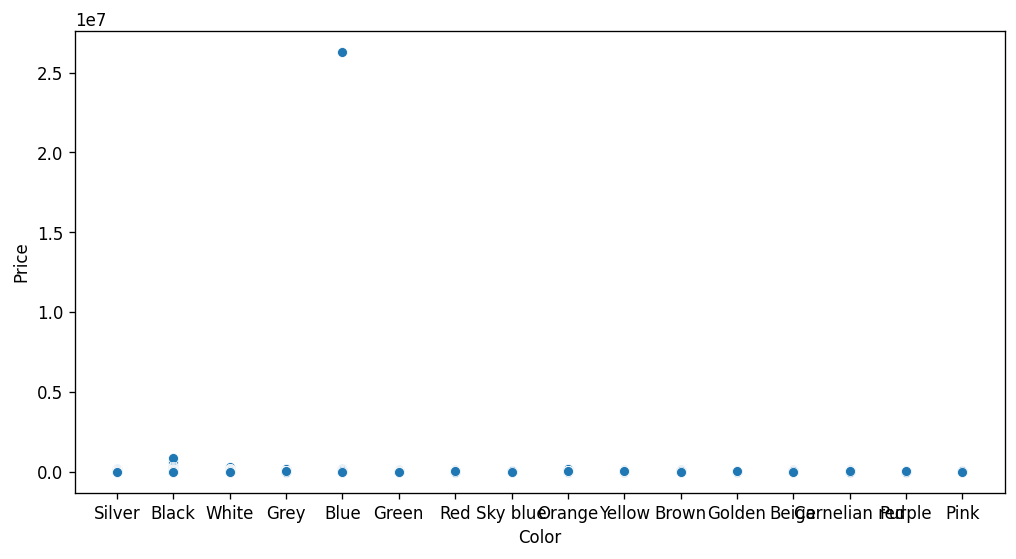

In [24]:
plt.figure(figsize=(10, 5), dpi=120)
sns.scatterplot(data=data, x='Color', y='Price', palette="crest")

#### Color dosen't seem to make significant difference on a car's price so we can remove it.

In [25]:
data = data.drop("Color",axis=1)

#### Checking and visualizing correlation between numerical columns:

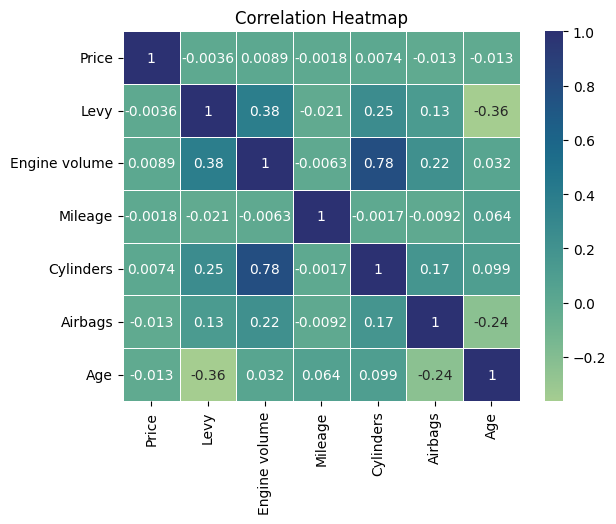

In [26]:
correlation_data = data.select_dtypes(exclude=object).corr()

correlation_data

sns.heatmap(correlation_data, annot= True, linewidths= 0.4,cmap='crest')
plt.title('Correlation Heatmap')
plt.show()

### Outlier detection and removal process

#### Visualizing in distribution plot to help us understand skewness and box plot to see median, IQR and outliers:

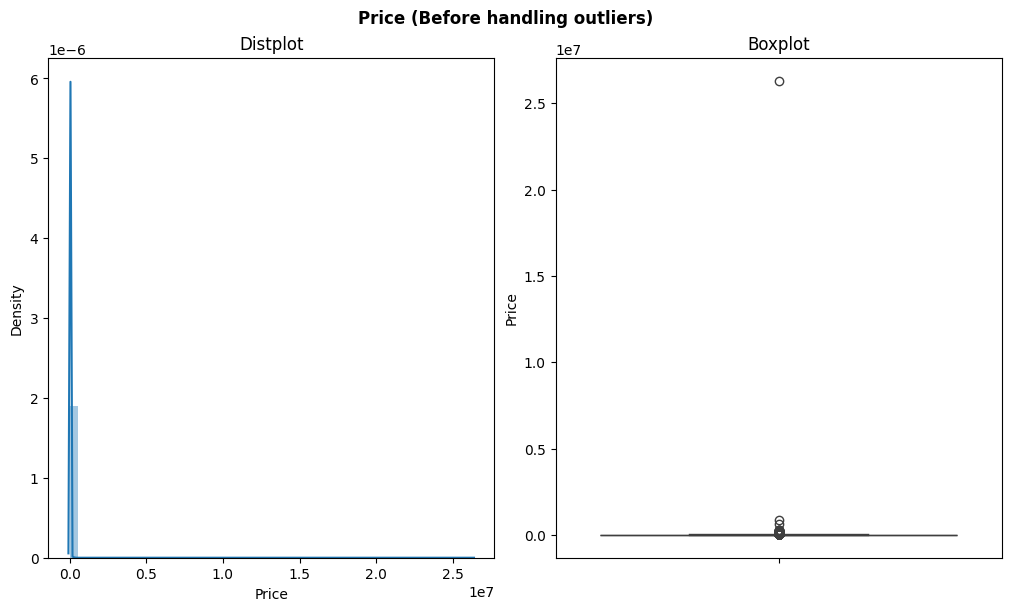

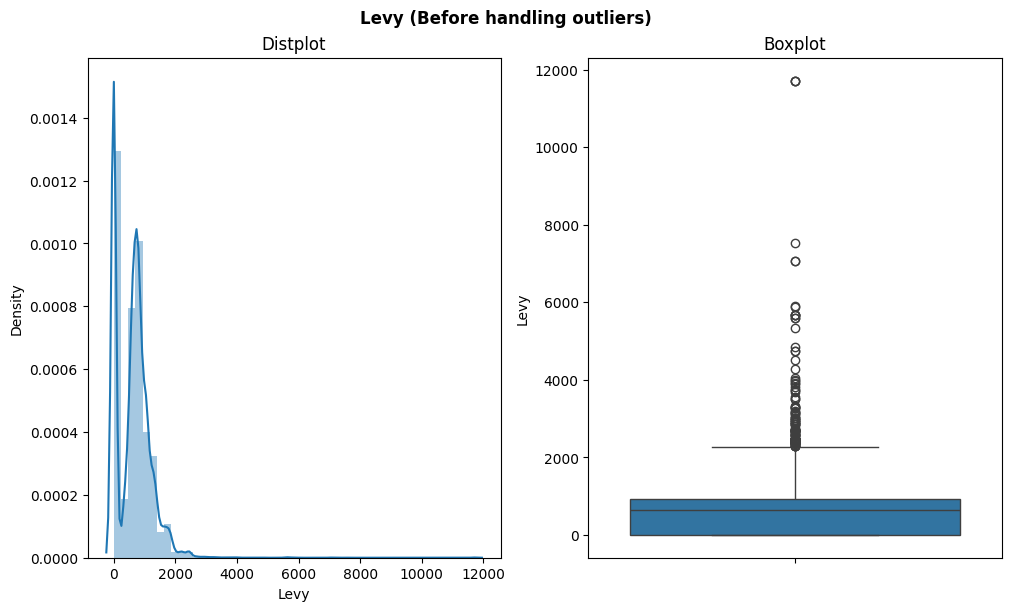

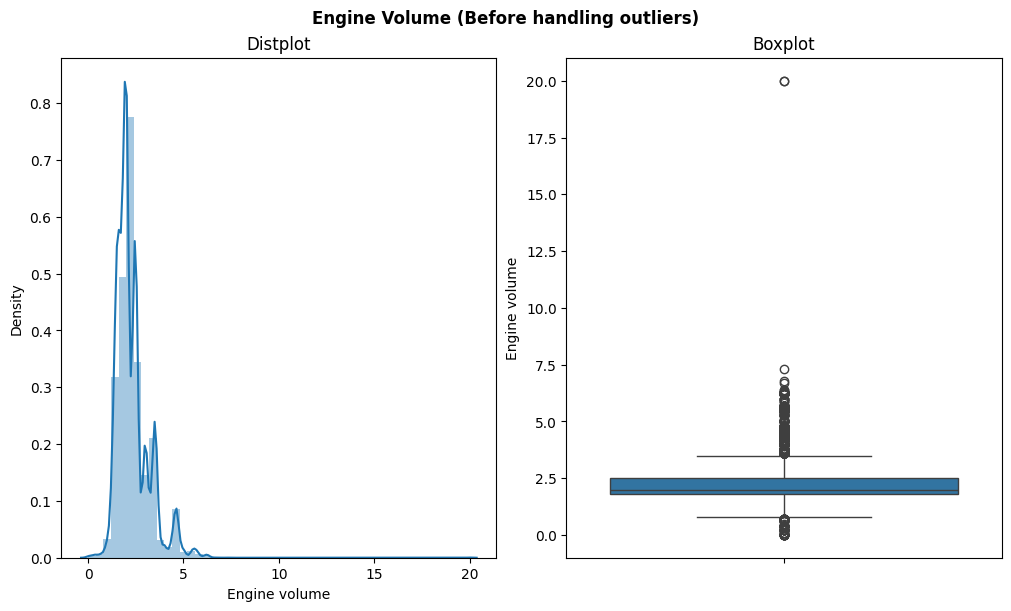

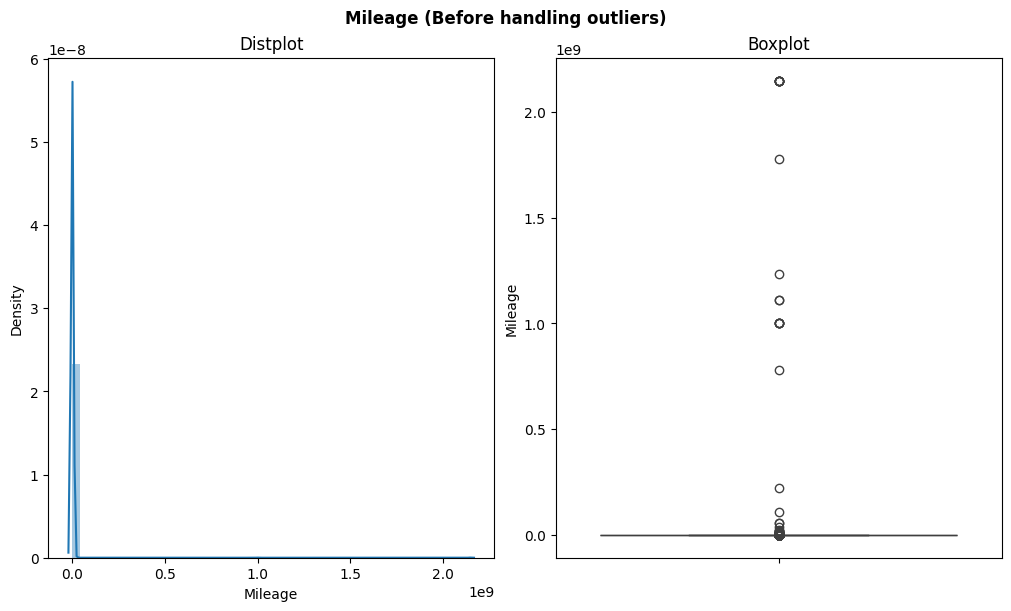

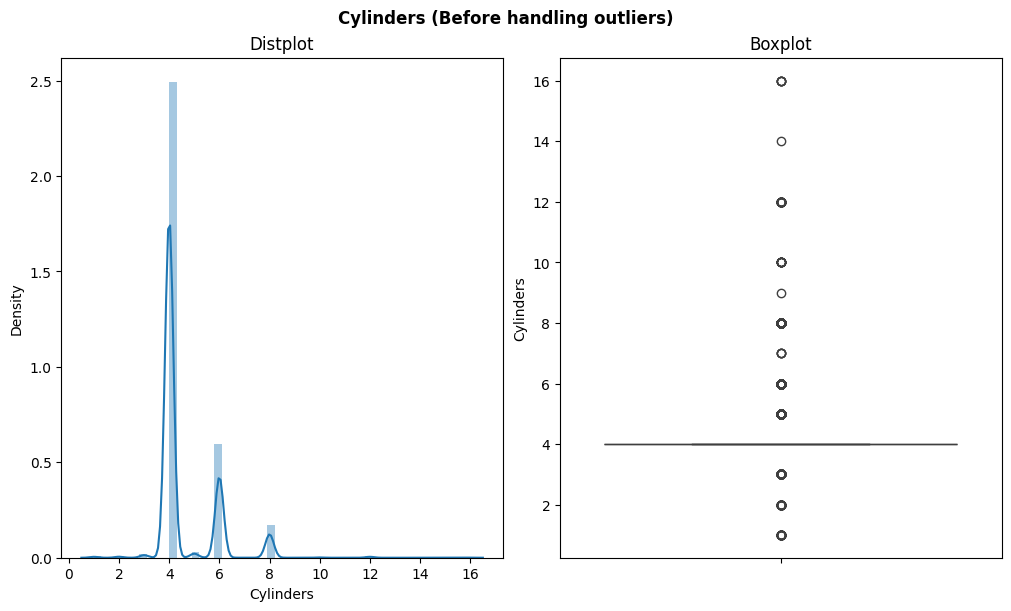

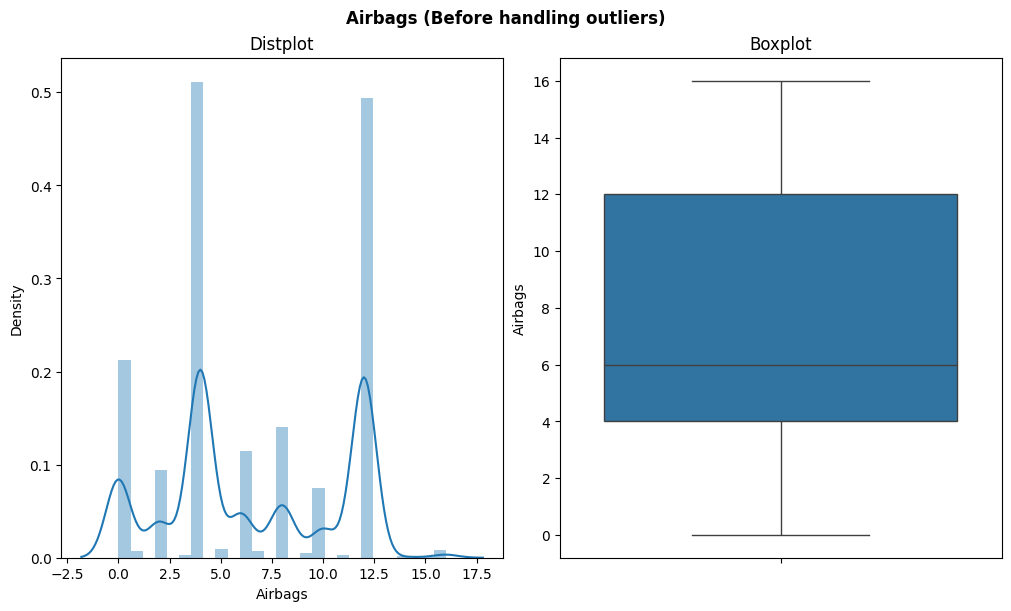

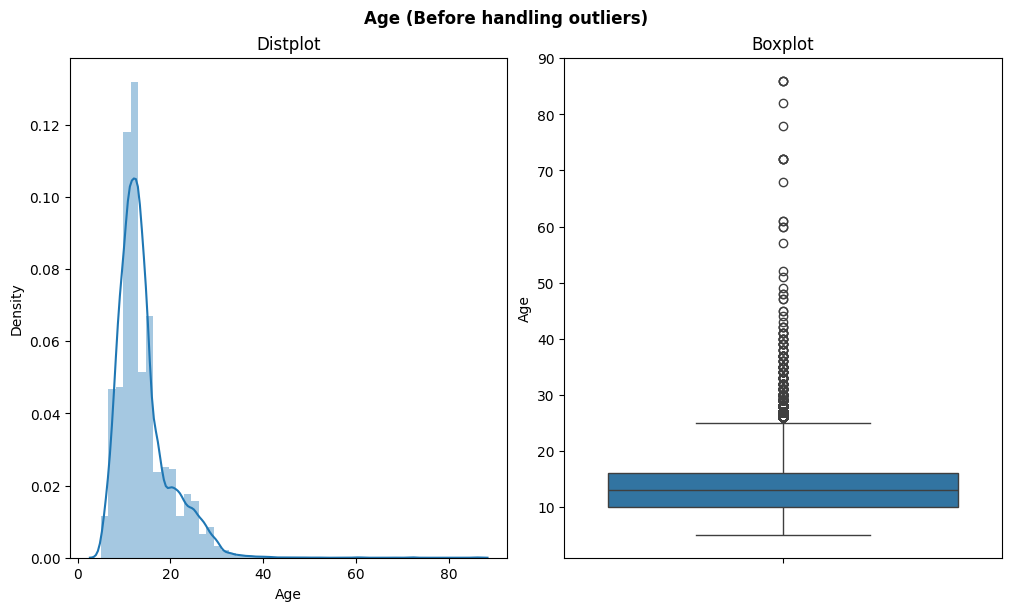

In [27]:
numeric_data = data.select_dtypes(exclude=object)

for col in numeric_data:
    fig, ax =plt.subplots(1,2, constrained_layout=True)
    fig.set_size_inches(10, 6)
    sns.distplot(data[col], ax=ax[0]).set(title="Distplot")
    sns.boxplot(data[col], ax=ax[1]).set(title="Boxplot")
    plt.suptitle(f'{col.title()} (Before handling outliers)',weight='bold')
    fig.show()

#### Calculating outliers for each column:

In [28]:
for col in numeric_data:
    q3 = data[col].quantile(0.75)
    q1 = data[col].quantile(0.25)
    iq = q3 - q1
    
    low = q1 - 1.5 * iq
    high = q3 + 1.5 * iq
    outlier = ((numeric_data[col] > high) | (numeric_data[col] < low)).sum()

    total = numeric_data[col].shape[0]
    print(f"Total Outliers in {col}: {outlier}, {round(100*(outlier)/total,2)}%")


Total Outliers in Price: 1055, 5.57%
Total Outliers in Levy: 160, 0.85%
Total Outliers in Engine volume: 1358, 7.18%
Total Outliers in Mileage: 635, 3.36%
Total Outliers in Cylinders: 4765, 25.18%
Total Outliers in Airbags: 0, 0.0%
Total Outliers in Age: 962, 5.08%


#### Removing outliers:

In [29]:
for col in numeric_data:
    q1 = data[col].quantile(0.75)
    q2 = data[col].quantile(0.25)
    iq = q1 - q2

    low = q2 - 1.5 * iq
    high = q1 + 1.5 * iq
    
    outlier = ((numeric_data[col] > high) | (numeric_data[col] < low)).sum()

    if outlier > 0:
        data = data.loc[(data[col] >= low) & (data[col] <= high)]

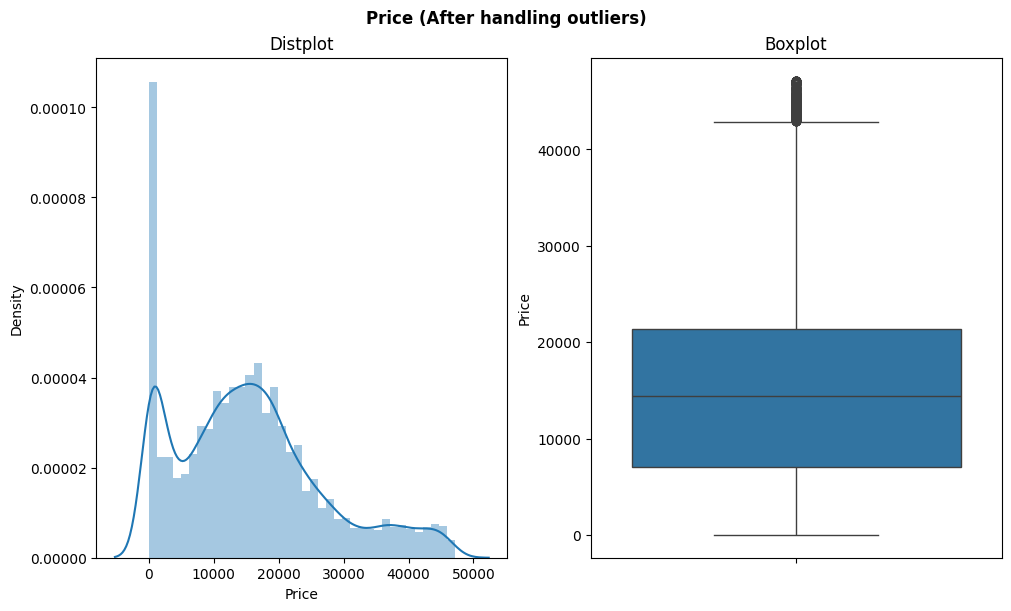

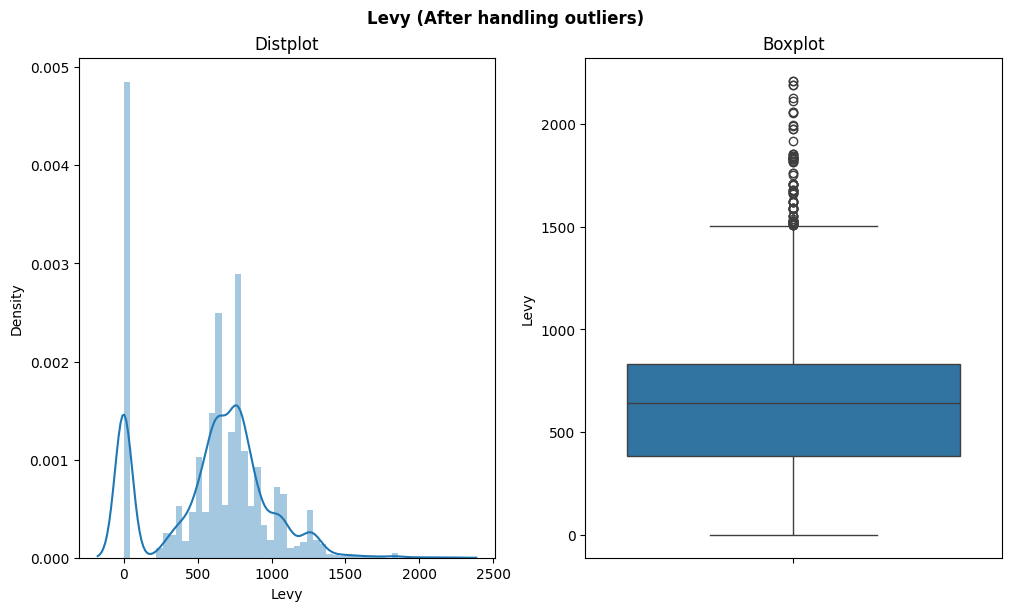

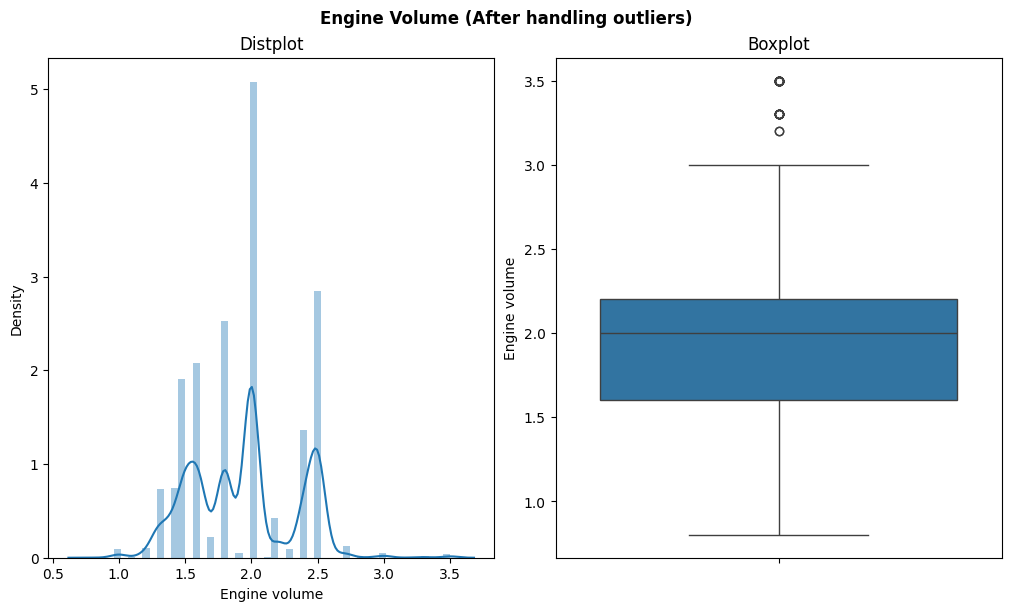

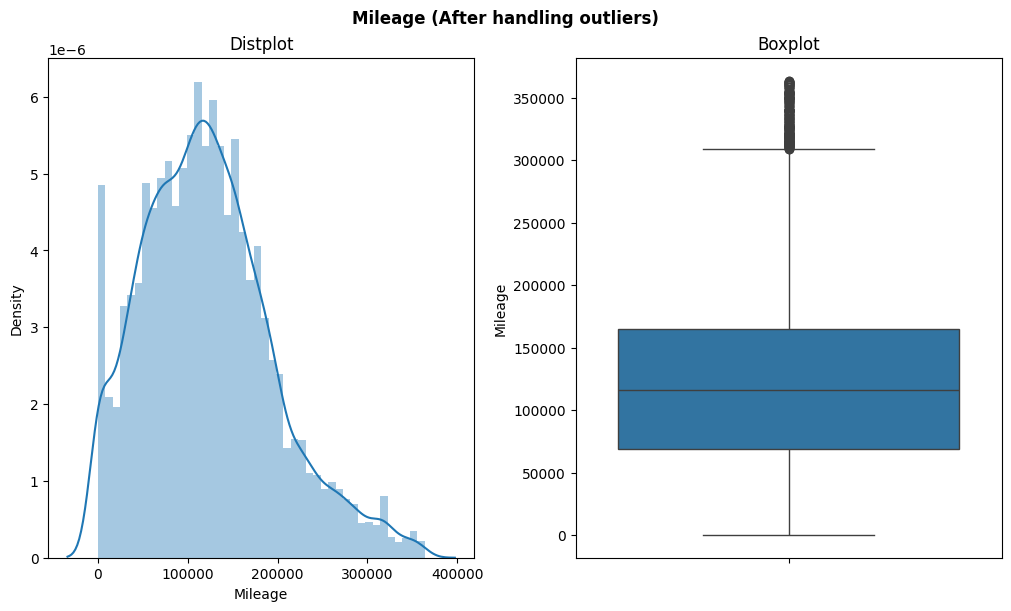

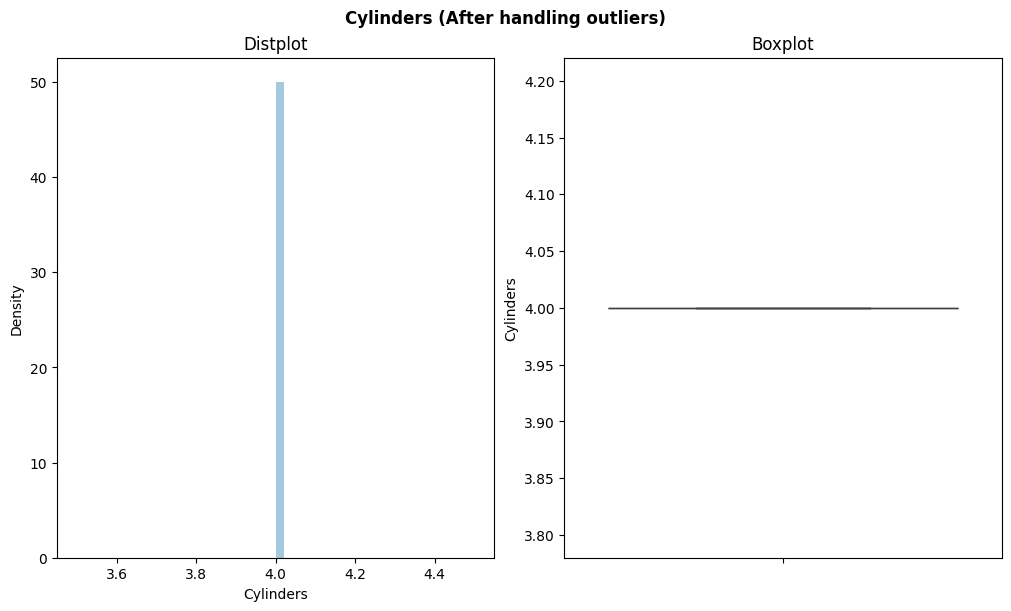

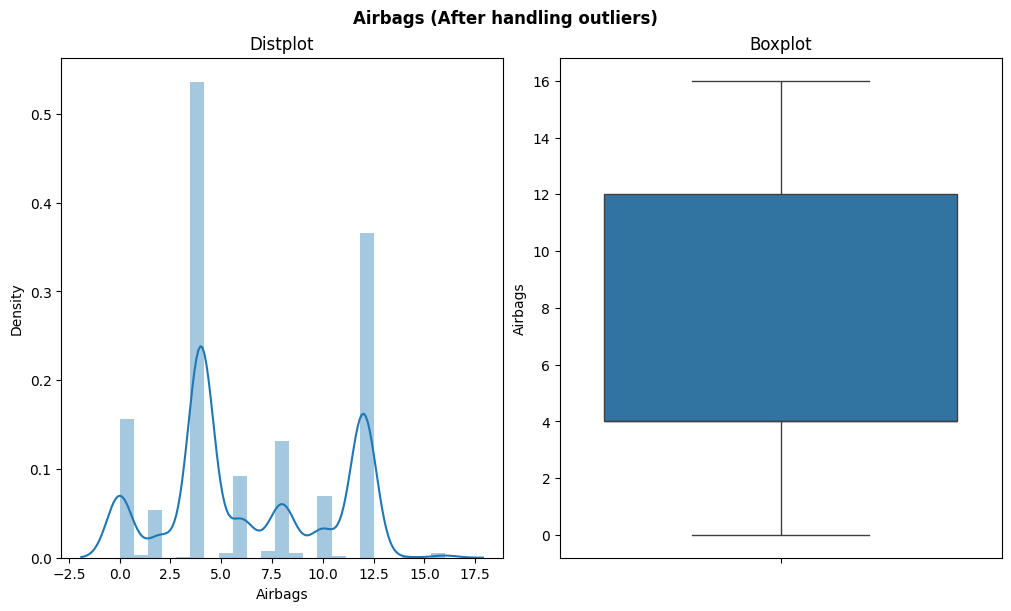

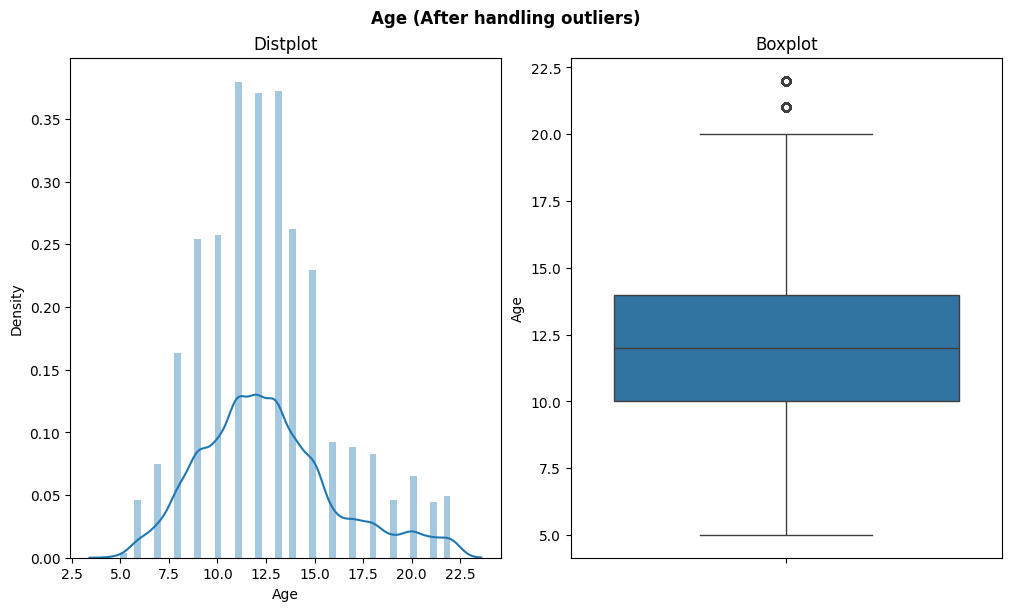

In [30]:
numeric_data = data.select_dtypes(exclude=object)

for col in numeric_data:
    fig, ax =plt.subplots(1,2, constrained_layout=True)
    fig.set_size_inches(10, 6)
    sns.distplot(data[col], ax=ax[0]).set(title="Distplot")
    sns.boxplot(data[col], ax=ax[1]).set(title="Boxplot")
    plt.suptitle(f'{col.title()} (After handling outliers)',weight='bold')
    fig.show()

#### Preparing data for model by using labelencoding becuase models can't directly work with non-numerical data (e.g., strings), so object columns need to be converted to numerical form:

In [31]:
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.preprocessing import LabelEncoder
lab = LabelEncoder()

import warnings
warnings.filterwarnings('ignore')

In [32]:
obdata = data.select_dtypes(include=object)
numdata = data.select_dtypes(exclude=object)

for i in range(0,obdata.shape[1]):
    obdata.iloc[:,i] = lab.fit_transform(obdata.iloc[:,i])  
    
data = pd.concat([obdata,numdata],axis=1)

In [33]:
data

,Manufacturer,Model,Category,Leather interior,Fuel type,Gear box type,Drive wheels,Wheel,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,Age
2,16,346,3,0,4,3,1,1,8467,0.0,1.3,200000,4,2,19
3,12,333,4,1,2,0,0,0,3607,862.0,2.5,168966,4,0,14
4,16,346,3,1,4,0,1,0,11726,446.0,1.3,91901,4,4,11
5,17,681,4,1,1,0,1,0,39493,891.0,2.0,160931,4,4,9
6,43,614,3,1,2,0,1,0,1803,761.0,1.8,258909,4,12,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19230,43,614,3,1,2,0,1,0,470,645.0,1.8,307325,4,12,14
19233,17,695,8,1,4,2,1,0,15681,831.0,2.4,161600,4,8,14
19234,17,767,4,1,1,0,1,0,26108,836.0,2.0,116365,4,4,15
19235,6,213,4,1,1,0,1,0,5331,1288.0,2.0,51258,4,4,18


### Model and prediction process

In [34]:
x= data.drop('Price',axis=1)
y= data['Price']

#### Splitting tests and train data:

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20,random_state=42)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#### Using different aglorithms:

In [36]:
algorithm = ['LinearRegression','DecisionTreeClassifier','RandomForestClassifier']
R2 = []
RMSE = []
Mae = []

def models(model):
    model.fit(x_train,y_train)
    pre = model.predict(x_test)
    r2 = r2_score(y_test,pre)
    rmse = np.sqrt(mean_squared_error(y_test,pre))
    mae = mean_absolute_error(y_test, pre)
    R2.append(r2)
    RMSE.append(rmse)
    Mae.append(mae)
    score = model.score(x_test,y_test)
    print(f'The Score of Model is :{score}')
    
model1 = LinearRegression()
model2 = DecisionTreeRegressor()
model3 = RandomForestRegressor()

models(model1)
models(model2)
models(model3)

df = pd.DataFrame({'Algorithm':algorithm, 'R2_score': R2, 'RMSE':RMSE, 'MAE': Mae})
df

The Score of Model is :0.24827504151331437
The Score of Model is :0.6314817819830093
The Score of Model is :0.7879221811274015


,Algorithm,R2_score,RMSE,MAE
0,LinearRegression,0.248275,9952.360868,7868.656105
1,DecisionTreeClassifier,0.631482,6968.288313,3940.440184
2,RandomForestClassifier,0.787922,5286.208080,3257.280099


#### Random forest classifer has the best performance across all metrics with the highest R2 Score and the lowest RMSE and MAE.

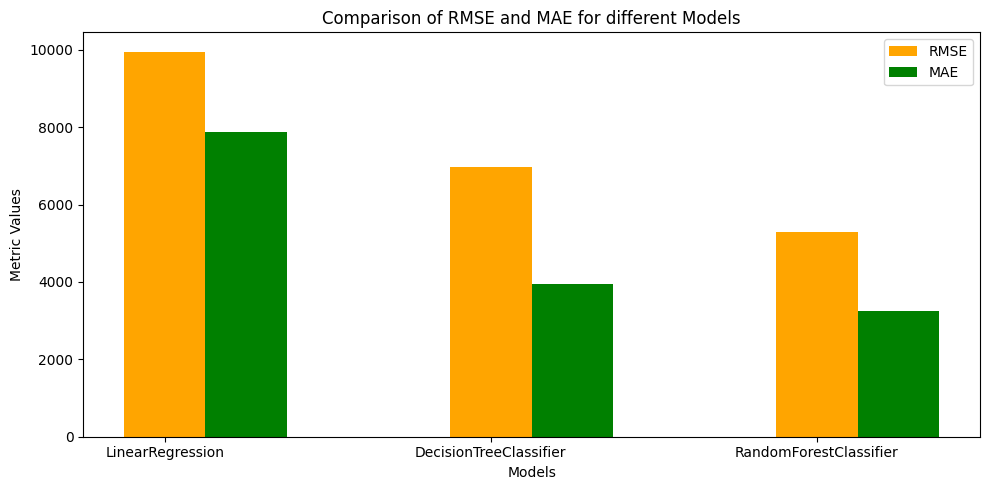

In [37]:
x = np.arange(len(algorithm))
bar_width = 0.25  

fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(x, RMSE, width=bar_width, label='RMSE', color='orange')
ax.bar(x + bar_width, Mae, width=bar_width, label='MAE', color='green')

ax.set_xticks(x)
ax.set_xticklabels(algorithm)
ax.set_title('Comparison of RMSE and MAE for different Models')
ax.set_xlabel('Models')
ax.set_ylabel('Metric Values')
ax.legend()

plt.tight_layout()
plt.show()

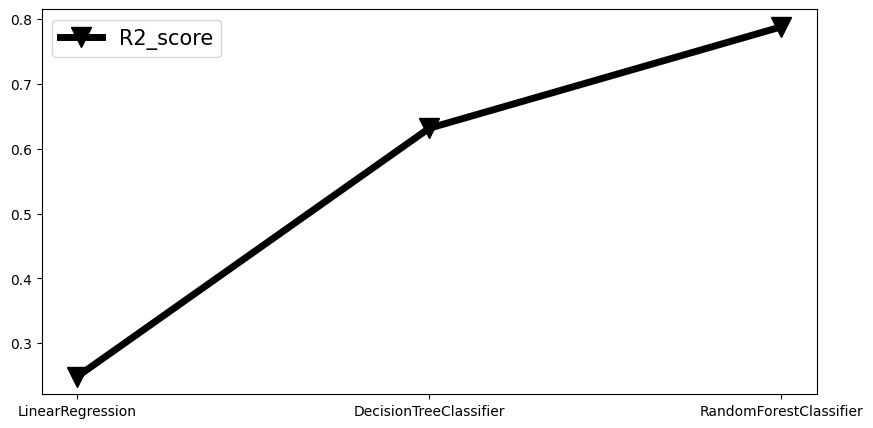

In [38]:
fig = plt.figure(figsize=(10,5))
plt.plot(df.Algorithm,df.R2_score ,label='R2_score',lw=5,color='black',marker='v',markersize = 15)
plt.legend(fontsize=15)
plt.show()

In [39]:
MAE_random_forest = Mae[2]  
mean_car_price = data['Price'].mean()

accuracy = (1 - (MAE_random_forest / mean_car_price)) * 100
print(accuracy, "% Accuracy")

78.96227598080495 % Accuracy


### Random Forest Regressor is the most suitable model for predicting car prices with a seudo-accuracy of 79% using the MAE divided by mean of the actual prices.